# ResNet

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.layers import Activation, Add, Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, concatenate, BatchNormalization, Dropout, Rescaling, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import L2
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

2022-11-08 19:28:58.081795: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# CONSTANTS

In [3]:
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, CHANNELS)
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'
BATCH_SIZE = 128
LR_INITIAL = 0.01
N_EPOCHS = 90

# DATASET

## train dataset

In [4]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


## validation/test dataset

In [5]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualization some examples

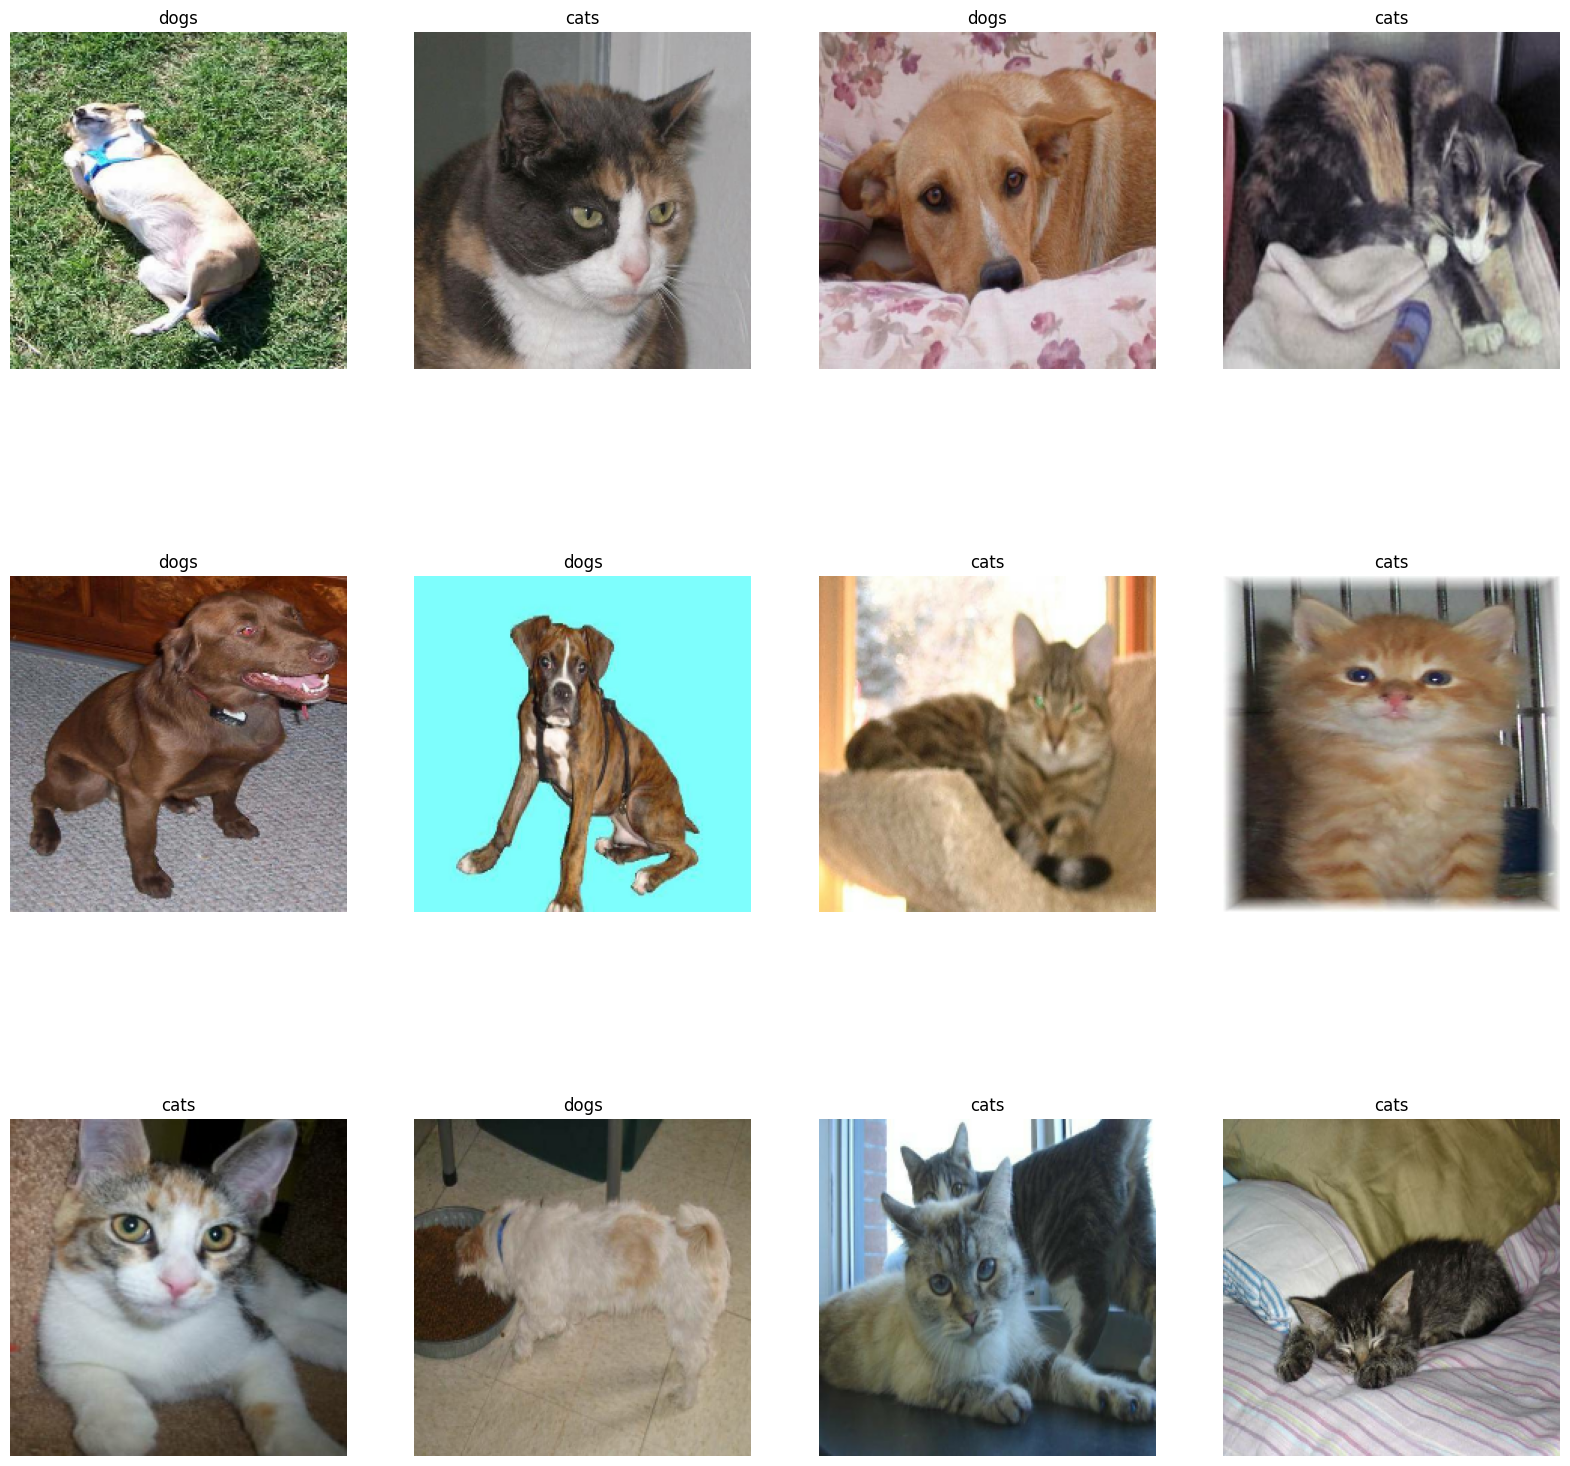

In [7]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL

In [9]:
def bottleneck_residual_block_34(X, kernel_size, filters, reduce=True, strides=1):
    
    F1, F2 = filters
    
    X_shortcut = X
    
    if reduce:
        # conv1x1
        X_shortcut = Conv2D(filters=F2,
                            kernel_size=(1, 1),
                            strides=(strides, strides),
                            padding='valid')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    
        # Conv 1
        X = Conv2D(filters=F1,
                   kernel_size=kernel_size,
                   strides=(strides, strides),
                   padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
    
    else:
        # Conv 1
        X = Conv2D(filters=F1,
                   kernel_size=kernel_size,
                   strides=(1, 1),
                   padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
    
    # Conv 2
    X = Conv2D(filters=F2,
               kernel_size=kernel_size,
               strides=(1, 1),
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## ResNet18

In [10]:
def ResNet18(input_shape, classes):
    X_input = Input(input_shape, name='Input Layer')
    X = Rescaling(1./255, offset=0.0)(X_input)
    X = Conv2D(filters=64,
               kernel_size=(7, 7),
               strides=(2, 2),
               activation='relu',
               padding='same',
               name='conv1')(X)
    X = BatchNormalization()(X)
    X = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(X)
    
    # Block 1
    X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(64, 64), reduce=False, strides=1)  
    #X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(64, 64), reduce=False, strides=1)    
    
    # Block 2
    X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(128, 128), reduce=True, strides=2)
    #X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(128, 128), reduce=False, strides=1)
    
    # Block 3
    X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(128, 128), reduce=True, strides=2)  # Original 256, 256
    #X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(256, 256), reduce=False, strides=1)
    
    # Block 4
    X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(128, 128), reduce=True, strides=2)  # Original 512, 512
    #X = bottleneck_residual_block_34(X=X, kernel_size=3, filters=(512, 512), reduce=False, strides=1)
    
    X = AveragePooling2D(pool_size=(1, 1))(X)
       
    X = Flatten()(X)
       
    X = Dense(classes, activation='softmax', name=f'fc{classes}')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet18')
    return model
    

In [11]:
model = ResNet18(input_shape=INPUT_SHAPE, classes=len(class_names))
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['Input Layer[0][0]']            
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['rescaling[0][0]']              
                                )                                                                 
                                                                                           

# CALLBACKS

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=10, min_lr=0.5e-6, verbose=1)

checkpoint_filepath = '/tmp/checkpoint/best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint_callback]

# OPTIMIZER

In [13]:
optimizer = SGD(learning_rate=LR_INITIAL, momentum=0.9)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [14]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [15]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=1)

Epoch 1/90
63/63 [==============================] - 19s 213ms/step - loss: 2.5979 - accuracy: 0.5431 - val_loss: 41.3378 - val_accuracy: 0.4905 - lr: 0.0100
Epoch 2/90
63/63 [==============================] - 11s 167ms/step - loss: 1.0815 - accuracy: 0.5784 - val_loss: 2.6472 - val_accuracy: 0.5385 - lr: 0.0100
Epoch 3/90
63/63 [==============================] - 11s 173ms/step - loss: 1.0088 - accuracy: 0.6440 - val_loss: 0.7577 - val_accuracy: 0.5910 - lr: 0.0100
Epoch 4/90
63/63 [==============================] - 11s 174ms/step - loss: 1.2213 - accuracy: 0.6340 - val_loss: 10.9709 - val_accuracy: 0.5580 - lr: 0.0100
Epoch 5/90
63/63 [==============================] - 11s 171ms/step - loss: 1.0015 - accuracy: 0.6476 - val_loss: 1.1248 - val_accuracy: 0.5580 - lr: 0.0100
Epoch 6/90
63/63 [==============================] - 11s 168ms/step - loss: 0.7756 - accuracy: 0.6894 - val_loss: 0.8309 - val_accuracy: 0.6890 - lr: 0.0100
Epoch 7/90
63/63 [==============================] - 11s 170ms/

# EVALUATING

In [16]:
model.load_weights('/tmp/checkpoint/best_model.h5')  # Loading the best model

In [17]:
model.evaluate(test_ds)

16/16 [==============================] - 1s 49ms/step - loss: 0.9828 - accuracy: 0.7345


[0.9827886819839478, 0.734499990940094]

In [18]:
out = model.evaluate(test_ds)
loss, acc = out[0], out[1]
print(f"loss = {loss:.4f} | acc = {acc:.4f}")

16/16 [==============================] - 1s 49ms/step - loss: 0.9828 - accuracy: 0.7345
loss = 0.9828 | acc = 0.7345


## Curves

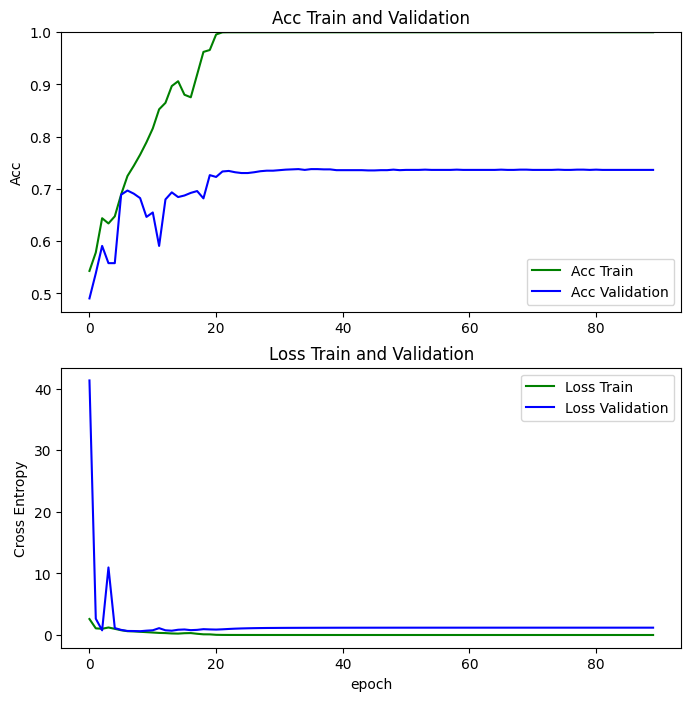

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

4/4 [==============================] - 0s 14ms/step


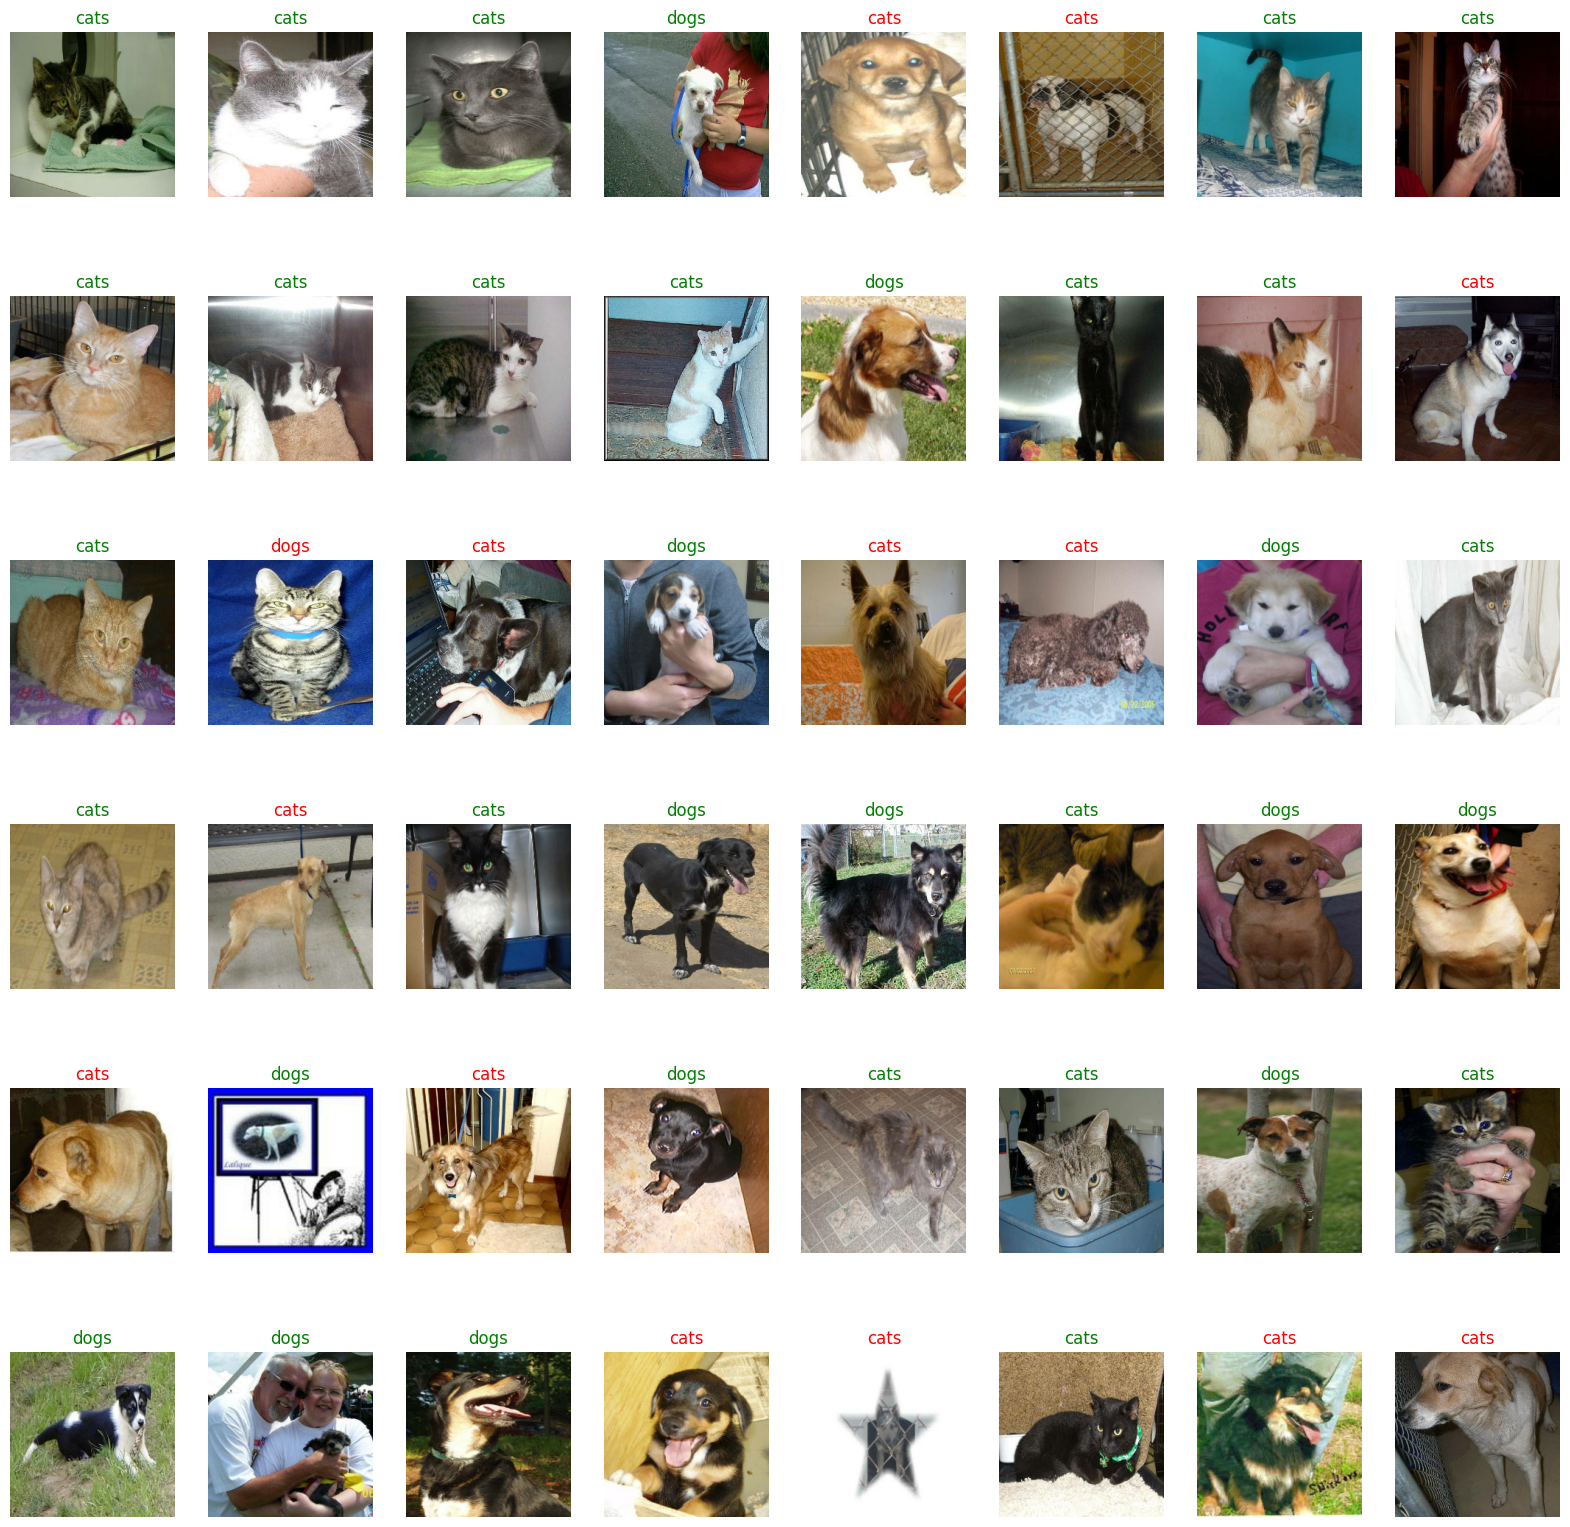

In [21]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images), axis=1)
    
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')